In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
# Use if you have jupyter matplotlib installed. Makes 3D graphs interactive.
# https://github.com/matplotlib/ipympl
%matplotlib widget

In [9]:
import pickle
import os

import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image
import numpy as np

In [10]:
base_dir = "/project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp"

import dataloading

# rsync command:
# rsync --ignore-existing --progress -avhze ssh Franka_TeleOp gsk6me@rivanna.hpc.virginia.edu:/project/CollabRoboGroup/gsk6me/real_frankadata

df = dataloading.get_demonstrations_index(base_dir)
df

,Participant,Task,Interface,Trial
0,1,1,2,1
1,1,1,3,1
2,1,3,1,1
3,1,3,2,1
4,1,3,3,2
...,...,...,...,...
411,34,6,1,1
412,34,6,2,1
413,34,6,3,1
414,34,8,1,1


In [11]:
# Find VR examples
all_data = []
successful_rows = []
vr_df = df[df['Interface'] == 3]

for i, row in vr_df.iterrows():
    participant_id, task_id, _, trial_id = row
    
    try:
        all_data.append(dataloading.get_vr_data(base_dir, participant_id, task_id, trial_id))
    except AssertionError:
        print("Missing:", row)
        continue
        
    successful_rows.append(row)


Missing: Participant    2
Task           3
Interface      3
Trial          1
Name: 19, dtype: int64
Missing: Participant    13
Task            3
Interface       3
Trial           1
Name: 95, dtype: int64
Missing: Participant    13
Task            5
Interface       3
Trial           1
Name: 98, dtype: int64
Missing: Participant    22
Task            2
Interface       3
Trial           1
Name: 216, dtype: int64


[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 152, 158, 163, 168, 175, 182, 188, 193, 198, 203, 209, 220, 226, 232, 237, 244, 249, 254, 262, 267, 272, 279, 284, 289, 294, 299, 304, 309, 314, 323, 328, 333, 343, 348, 353, 358, 363, 370, 375, 381, 386, 391, 400, 405, 411, 416, 421, 426, 431, 439, 444, 449, 454, 464, 469, 474, 484, 489, 494, 502, 507, 515, 520, 525, 530, 540, 545, 554, 559, 567, 572, 577, 582, 593, 598, 603, 608, 611]


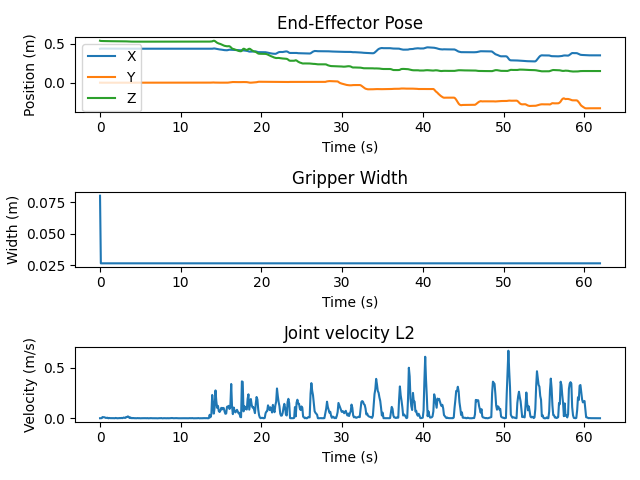

In [101]:
import matplotlib.pyplot as plt
from detect_keypoints import find_keypoints

result = dataloading.collate_observations(all_data[15])
keypoints = find_keypoints(result)
# Will need a better keypoint detection method, or some other way to encode motion plans.
print(keypoints)

dataloading.plot_demonstration(result)

In [13]:
# Group observations by Task ID
for task_id, indices in vr_df.groupby('Task').groups.items():
    print(f"Task ID {task_id}: {indices.tolist()}")
    
for i, row in enumerate(successful_rows):
    if row.name == 59:
        print(i)

Task ID 1: [1, 14, 30, 44, 59, 73, 74, 90, 104, 117, 131, 143, 157, 171, 186, 262]
Task ID 2: [216, 230, 248, 282, 296, 314, 331, 345, 362, 378, 393, 406]
Task ID 3: [4, 18, 19, 34, 49, 62, 63, 77, 94, 95, 107, 121, 134, 146, 161, 191, 192, 206]
Task ID 4: [219, 220, 233, 252, 268, 269, 270, 286, 299, 300, 301, 317, 335, 349, 350, 365, 366, 382, 383, 397, 409]
Task ID 5: [22, 23, 37, 52, 66, 81, 82, 97, 98, 110, 125, 137, 150, 164, 178, 196, 209]
Task ID 6: [223, 236, 256, 257, 275, 289, 305, 322, 323, 339, 355, 356, 357, 369, 386, 401, 413]
Task ID 7: [27, 41, 55, 70, 87, 101, 113, 128, 140, 154, 167, 181, 199, 200, 212]
Task ID 8: [226, 239, 261, 279, 292, 310, 327, 342, 374, 390, 404]
Task ID 10: [243]
15


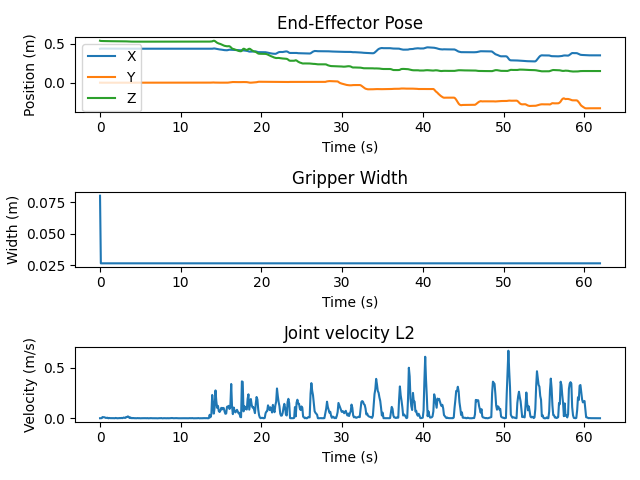

In [23]:
plt.clf()
dataloading.plot_demonstration(dataloading.collate_observations(all_data[15]))

1
(612, 8) 613
1700144814.1630065 1700144873.8856573
1700144831.9031909 1700144893.8487427
1 1722
(1280, 720)


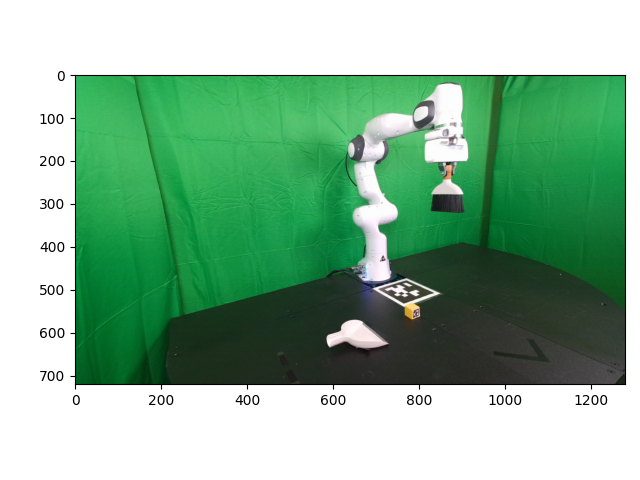

In [30]:
data_id = 15
target_timestamp = 0

participant_id, task_id, interface_id, trial_id = successful_rows[data_id]
obs = dataloading.get_observations(base_dir, participant_id, task_id, interface_id, trial_id)

datum = all_data[data_id]
control_index = np.where((np.array(datum['timestamps']) - datum['timestamps'][0]) > target_timestamp)[0][0]

print(control_index)
print(np.stack(datum['actions']).shape, len(datum['observations']))

print(obs['data']['kinect1']['timestamps'][0], obs['data']['kinect1']['timestamps'][-1])
print(datum['timestamps'][0], datum['timestamps'][-1])

ts = np.array(obs['data']['kinect1']['timestamps'])
ts = ts - obs['data']['kinect1']['timestamps'][0] # datum['timestamps'][0]
for kinect_index in range(len(ts)):
    if ts[kinect_index] > target_timestamp:
        break
        
print(kinect_index, len(ts) - 1)

image_path = os.path.join(obs['root'], "kinect1_color", obs['data']['kinect1']['color_image_paths'][kinect_index])
image = PIL.Image.open(image_path)
print(image.size)
plt.clf()
plt.imshow(np.array(image))
plt.show()

## Camera Calibration

We will now attempt to calculate camera extrinsic matrices based on AprilTags.

::: Detected AprilTags :::
({'hamming': 0, 'margin': 168.65310668945312, 'id': 0, 'center': array([768.65313783, 503.66335501]), 'lb-rb-rt-lt': array([[765.57391357, 533.3215332 ],
       [835.61749268, 508.26611328],
       [771.20220947, 479.1114502 ],
       [704.59576416, 499.26040649]])},)
[[879.30187428 165.89792704]
 [880.9798921  168.32368686]
 [880.97961206 168.32312487]
 ...
 [680.39532795 460.84013965]
 [680.4004001  460.83897822]
 [680.4022433  460.83785251]]


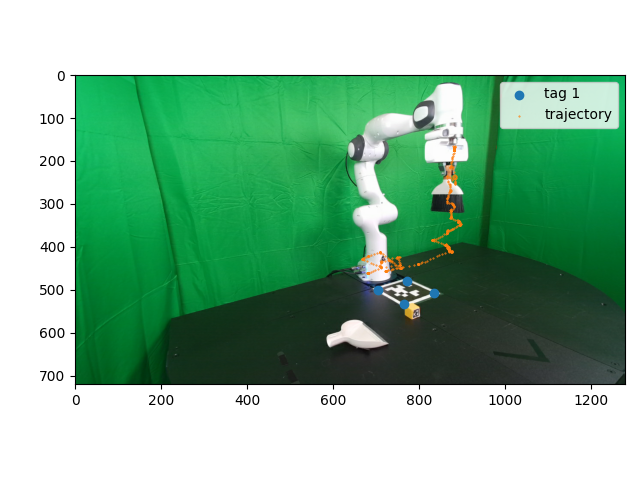

[ 4.36069995e-01 -5.23110153e-04  5.30396581e-01]


In [152]:
from apriltag import apriltag
import cv2

from camera_calibration import \
    left_camera_intrinsic_matrix, left_camera_dist_coeffs, \
    right_camera_intrinsic_matrix, right_camera_dist_coeffs

apriltag_object_points = np.array([
    # order: left bottom, right bottom, right top, left top
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 0],
    [0, 0, 0],
]).astype(np.float32)

demo_cube_object_points = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [1, 0, 0],
    [1, 1, 0],
    [0, 0, 1],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 1],
]).astype(np.float32)

datum_collated = dataloading.collate_observations(datum)

INDEX = 0
image_path = os.path.join(obs['root'], "kinect1_color", obs['data']['kinect1']['color_image_paths'][INDEX])
image = PIL.Image.open(image_path)
displayed_timestamp = obs['data']['kinect1']['timestamps'][INDEX] - obs['data']['kinect1']['timestamps'][0]

# try creating extrinsic matrix
import numpy as np

image_array = np.array(image)
image_gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
detector = apriltag("tag36h11")
detections = detector.detect(image_gray)

print("::: Detected AprilTags :::")
print(detections)

# Wait. I don't really need to use the AprilTag to calibrate here. I can just label the robot arm positions on the image
# and use the corresponding 3D positions to solve the PnP.

plt.clf()
plt.imshow(image_array)
for i, detection in enumerate(detections):
    points = detection['lb-rb-rt-lt']
    x, y = points.T
    plt.scatter(x, y, label='tag ' + str(i + 1))

    # ret, rvec, tvec = cv2.solvePnP(apriltag_object_points, points, left_camera_intrinsic_matrix, left_camera_dist_coeffs)
    measured_object_points = np.array([
        [4.33868378e-01, 5.37152482e-05, 5.37024200e-01],
        [0.39762837, 0.0006968, 0.41472846],
        [0.37399399, 0.00955128, 0.24610548],
        [0.34978241, -0.32743371, 0.14896235],
        [ 0.42864648, -0.16139126, 0.15062304],
        [0.34978241, -0.32743371, 0.14896235],
    ])
    image_points = np.array([
        [879, 150],
        [870, 243],
        [865, 343],
        [667, 461],
        [795, 458],
        [723, 446],
    ]).astype(np.float32)
    ret, rvec, tvec = cv2.solvePnP(measured_object_points, image_points, left_camera_intrinsic_matrix, left_camera_dist_coeffs)
    # ret, rvec, tvec = cv2.solvePnP(apriltag_object_points, points, left_camera_intrinsic_matrix, left_camera_dist_coeffs)
    
    # cube_image_points, _jacobian = cv2.projectPoints(demo_cube_object_points, rvec, tvec, left_camera_intrinsic_matrix, left_camera_dist_coeffs)
    # cube_image_points = cube_image_points[:, 0, :]
    # plt.scatter(*cube_image_points.T, label='tag ' + str(i + 1) + ' cube points')

    # Plot the time series for the run
    # trajectory_image_points, _jacobian = cv2.projectPoints(datum_collated['ee_pos'] * 4.5 + np.array([0.05, 0.05, 1.6]), rvec, tvec, left_camera_intrinsic_matrix, left_camera_dist_coeffs)
    trajectory_image_points, _jacobian = cv2.projectPoints(datum_collated['ee_pos'], rvec, tvec, left_camera_intrinsic_matrix, left_camera_dist_coeffs)
    trajectory_image_points = trajectory_image_points[:, 0, :]
    print(trajectory_image_points)
    plt.scatter(*trajectory_image_points.T, label='trajectory', s=0.2)
    
    break

plt.legend()
plt.show()

# use these calculated image points to draw the trajectory in the next cell

datum_index = 0
transformed_timestamps = datum_collated['timestamp'] - datum_collated['timestamp'][0] - 2

while transformed_timestamps[datum_index] < displayed_timestamp:
    datum_index += 1

print(datum_collated['ee_pos'][datum_index])

# start: (879, 150) / xyz: [4.33868378e-01, 5.37152482e-05, 5.37024200e-01]
# 500: (870, 243) / xyx: [0.39762837, 0.0006968, 0.41472846]
# 700: (865, 363) / xyz: [0.37399399, 0.00955128, 0.24610548]
# 1200: (795, 458) / xyz: [ 0.42864648, -0.16139126, 0.15062304]
# 1400: (723, 446) / xyz: [ 0.36470962, -0.24052101, 0.15992852]
# end: (667, 461) / xyz: [0.34978241, -0.32743371, 0.14896235]


In [149]:
# Try generating a video instead

import cv2
import tqdm

fps = 20

fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter('output.avi', fourcc, fps, (1280, 720))  # Change resolution if needed

data_id = 15
robot_states = all_data[data_id]
participant_id, task_id, interface_id, trial_id = successful_rows[data_id]
obs = dataloading.get_observations(base_dir, participant_id, task_id, interface_id, trial_id)

prev_written_timestamp = -1

# Plot the predicted end-effector position as well

observation_index = 0

# normalize both according to self
ts_obs = obs['data']['kinect1']['timestamps']
ts_obs = np.array(ts_obs) - ts_obs[0]
ts_datum = np.array(datum_collated['timestamp'])
ts_datum = ts_datum - ts_datum[0] - 2.1

for ts, path in tqdm.tqdm(zip(ts_obs, obs['data']['kinect1']['color_image_paths']), desc='Generating video...', total=len(obs['data']['kinect1']['timestamps'])):
    if ts - prev_written_timestamp >= 1/fps:
        prev_written_timestamp = ts
        image_path = os.path.join(obs['root'], "kinect1_color", path)
        image = PIL.Image.open(image_path)
        image_np = np.array(image)
        
        # get closest observation: o(n)
        while observation_index < len(ts_datum) and ts_datum[observation_index] < ts:
            observation_index += 1
            
        if observation_index < len(ts_datum):
            traj_x, traj_y = trajectory_image_points[observation_index].astype(int)
            cv2.circle(image_np, (traj_x, traj_y), 5, (0, 255, 0), 3)
        
        output_video.write(image_np)

output_video.release()

Generating video...: 100%|██████████| 1723/1723 [00:20<00:00, 82.76it/s]


In [135]:
import numpy as np
import json

demo_index = 0

mask = []

while demo_index < len(df):
    try:
        participant_id, task_id, inferface_id, trial_id = df.iloc[demo_index]

        data = get_teleoperation_index(base_dir, participant_id, task_id, interface_id, trial_id)
        
        t = [d['unix_time_stamp'] for d in data]
        x = [d['eef_pos']['x'] for d in data]
        y = [d['eef_pos']['y'] for d in data]
        z = [d['eef_pos']['z'] for d in data]
        t = np.array(t) - t[0]
        
        # t = data['unix_time_stamp'].to_numpy()
        # t = t - t[0]
        # eef = [json.loads(s.replace("'", "\"").lower()) for s in data['eef_pos'].tolist()]
        # x = [d['x'] for d in eef]
        # y = [d['y'] for d in eef]
        # z = [d['z'] for d in eef]

        if max(x) - min(x) == 0:
            # assume blank run
            raise ValueError("empty dataset")

        plt.title("Teleoperation data")
        plt.plot(t, x, label='X')
        plt.plot(t, y, label='Y')
        plt.plot(t, z, label='Z')
        plt.show()
        
        mask.append(True)
    except Exception as e:
        print(e)
        mask.append(False)
    
    demo_index += 1

empty dataset
empty dataset
[Errno 2] No such file or directory: '/project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp/Joystick_SpaceMouse_Interface/P_1/Task_3/Interface_2/Trial_1/robot_data_1_3_2_1.pkl'
[Errno 2] No such file or directory: '/project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp/Joystick_SpaceMouse_Interface/P_1/Task_3/Interface_2/Trial_1/robot_data_1_3_2_1.pkl'
Teleoperation folder does not exist: /project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp/Joystick_SpaceMouse_Interface/P_1/Task_3/Interface_2/Trial_2
Teleoperation folder does not exist: /project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp/Joystick_SpaceMouse_Interface/P_1/Task_5/Interface_2/Trial_2
empty dataset
empty dataset
Teleoperation folder does not exist: /project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp/Joystick_SpaceMouse_Interface/P_1/Task_7/Interface_2/Trial_2
empty dataset
empty dataset
empty dataset
empty dataset
empty dataset
empty dataset
Teleoperat

In [ ]:
base_dir = "/project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp"
img = PIL.Image.open(base_dir + "/RGB_Data/P_19/Task_3/Interface_1/Trial_1/rs_color/color_frame_293_1700254934.6310108.png")
plt.imshow(img)